# Consensus Docking Results Analysis - Polars Version

This notebook has been **optimized for memory efficiency** by using **Polars** instead of pandas throughout.

## Key Improvements:
- **Memory Efficiency**: Polars uses significantly less memory than pandas
- **Speed**: Faster data loading, filtering, and aggregations
- **Lazy Evaluation**: More efficient processing of large datasets
- **Better Type System**: More precise data types reduce memory usage

## What Changed:
1. **All DataFrames are now Polars DataFrames** instead of pandas
2. **All data operations use Polars syntax** (`.filter()`, `.group_by()`, `.agg()`, etc.)
3. **Archive reading is optimized** for direct loading into Polars
4. **Plotting cells convert to pandas only when needed** for visualization
5. **File I/O uses Polars methods** (`.write_parquet()`, `.read_parquet()`)

## Variable Names:
- `combined_results`: Main Polars DataFrame with all docking results and metadata
- `filtered_data`: Polars DataFrame after applying scoring cutoffs (created in analysis cells)

**Memory Usage**: Polars typically uses 30-50% less memory than pandas for the same data!

In [1]:
import os
import re
from pathlib import Path
import polars as pl
from tqdm import tqdm

# Configuration
BASE_FOLDER = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/consensus_docking_results"
TARGET_FILENAME = "final_results.csv"

print("Libraries imported successfully!")
print(f"Base folder: {BASE_FOLDER}")
print(f"Target filename: {TARGET_FILENAME}")

Libraries imported successfully!
Base folder: /media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/consensus_docking_results
Target filename: final_results.csv


In [ ]:
# Create a tar.gz containing just final_results.csv files from the BASE_FOLDER.
# You will only need to load this archive later to analyze the results.
import subprocess
import time

def create_archive_with_find(base_folder, output_archive_path):
    """
    Use system 'find' and 'tar' commands for potentially faster archiving
    This is usually much faster than Python's file walking, especially over USB
    """
    print(f"Creating archive using system commands: {output_archive_path}")
    print(f"Base folder: {base_folder}")
    
    start_time = time.time()
    
    # First, count files for progress indication
    count_cmd = f"find '{base_folder}' -name 'final_results.csv' | wc -l"
    result = subprocess.run(count_cmd, shell=True, capture_output=True, text=True)
    total_files = int(result.stdout.strip())
    print(f"Found {total_files} final_results.csv files")
    
    # Create tar.gz using find and tar
    # This command finds all final_results.csv files and pipes them to tar
    tar_cmd = f"""
    cd '{base_folder}' && \
    find . -name 'final_results.csv' -print0 | \
    tar -czf '{os.path.abspath(output_archive_path)}' --null -T -
    """
    
    print("Creating archive with system commands...")
    result = subprocess.run(tar_cmd, shell=True, capture_output=True, text=True)
    
    if result.returncode == 0:
        elapsed_time = time.time() - start_time
        archive_size = os.path.getsize(output_archive_path) / (1024*1024)
        print(f"Archive created successfully in {elapsed_time:.2f} seconds")
        print(f"Archive size: {archive_size:.2f} MB")
        print(f"Files per second: {total_files/elapsed_time:.1f}")
    else:
        print(f"Error creating archive: {result.stderr}")
    
    return output_archive_path

# Uncomment to use the faster system command method:
archive_path_fast = os.path.join("/home/onur/experiments/cavity_space_consensus_docking/2025_06_29_batch_dock","final_results_archive_fast.tar.gz") 
create_archive_with_find(BASE_FOLDER, archive_path_fast)

In [2]:
import polars as pl
import tarfile
import io
from pathlib import Path
import re

def extract_metadata_from_folder_name(folder_path):
    """
    Extract metadata from folder name, compatible with the original metadata extraction logic.
    
    Args:
        folder_path (str): Path to the folder (e.g., "DB00001_GENE1_P12345_cavity_1")
    
    Returns:
        dict: Dictionary with extracted metadata
    """
    folder_name = Path(folder_path).name
    
    # Initialize metadata with defaults
    metadata = {
        'drugbank_id': 'unknown',
        'gene_name': 'unknown', 
        'uniprot_id': 'unknown',
        'cavity_index': 'unknown',
        'folder_name': folder_name
    }
    
    try:
        # Common pattern: DrugBankID_GeneName_UniProtID_cavity_N
        # Examples: "DB00001_ACE_P12821_cavity_1"
        pattern = r'^(DB\d+)_([^_]+)_([^_]+)_cavity_(\d+)$'
        match = re.match(pattern, folder_name)
        
        if match:
            metadata.update({
                'drugbank_id': match.group(1),
                'gene_name': match.group(2),
                'uniprot_id': match.group(3),
                'cavity_index': int(match.group(4))
            })
        else:
            # Try alternative patterns or partial matches
            parts = folder_name.split('_')
            if len(parts) >= 3:
                # Try to identify DrugBank ID (starts with DB)
                for i, part in enumerate(parts):
                    if part.startswith('DB') and len(part) >= 5:
                        metadata['drugbank_id'] = part
                        if i + 1 < len(parts):
                            metadata['gene_name'] = parts[i + 1]
                        if i + 2 < len(parts):
                            metadata['uniprot_id'] = parts[i + 2]
                        break
                
                # Look for cavity number
                for part in parts:
                    if part.isdigit():
                        metadata['cavity_index'] = int(part)
                        break
                    elif part.startswith('cavity') and len(parts) > parts.index(part):
                        try:
                            cavity_idx = parts.index(part) + 1
                            if cavity_idx < len(parts) and parts[cavity_idx].isdigit():
                                metadata['cavity_index'] = int(parts[cavity_idx])
                        except:
                            pass
    
    except Exception as e:
        print(f"Warning: Could not parse folder name '{folder_name}': {e}")
    
    return metadata

def read_csv_files_from_archive_with_polars(archive_path, output_parquet_path=None):
    """
    Read all final_results.csv files directly from tar.gz archive using Polars
    and combine them into a single DataFrame with proper metadata extraction
    
    Args:
        archive_path (str): Path to the tar.gz archive
        output_parquet_path (str, optional): Path to save combined data as parquet
    
    Returns:
        pl.DataFrame: Combined dataframe from all CSV files with metadata
    """
    print(f"Reading CSV files from archive using Polars: {archive_path}")
    
    all_dataframes = []
    processed_files = 0
    
    with tarfile.open(archive_path, 'r:gz') as tar:
        # Get all members (files) in the archive
        members = [m for m in tar.getmembers() if m.name.endswith('final_results.csv')]
        total_files = len(members)
        
        print(f"Found {total_files} final_results.csv files in archive")
        
        for member in members:
            try:
                # Extract file content to memory
                file_obj = tar.extractfile(member)
                if file_obj:
                    # Read CSV directly from memory using Polars
                    csv_content = file_obj.read()
                    df = pl.read_csv(io.BytesIO(csv_content))
                    
                    # Extract folder path and metadata
                    folder_path = str(Path(member.name).parent)
                    metadata = extract_metadata_from_folder_name(folder_path)
                    
                    # Add metadata columns using Polars syntax
                    df = df.with_columns([
                        pl.lit(metadata['drugbank_id']).alias('drugbank_id'),
                        pl.lit(metadata['gene_name']).alias('gene_name'),
                        pl.lit(metadata['uniprot_id']).alias('uniprot_id'),
                        pl.lit(metadata['cavity_index']).alias('cavity_index'),
                        pl.lit(metadata['folder_name']).alias('folder_name'),
                        pl.lit(member.name).alias('source_file'),
                        pl.lit(folder_path).alias('source_folder')
                    ])
                    
                    all_dataframes.append(df)
                    processed_files += 1
                    
                    if processed_files % 100 == 0:
                        print(f"Processed {processed_files}/{total_files} files...")
                        
            except Exception as e:
                print(f"Error reading {member.name}: {e}")
                continue
    
    print(f"Successfully read {len(all_dataframes)} CSV files")
    
    if all_dataframes:
        # Combine all dataframes using Polars
        print("Combining all dataframes...")
        combined_df = pl.concat(all_dataframes, how="vertical")
        print(f"Combined dataframe shape: {combined_df.shape}")
        
        # Show metadata statistics using Polars methods
        print(f"\nMetadata extraction results:")
        print(f"Unique DrugBank IDs: {combined_df['drugbank_id'].n_unique()}")
        print(f"Unique Gene Names: {combined_df['gene_name'].n_unique()}")
        print(f"Unique UniProt IDs: {combined_df['uniprot_id'].n_unique()}")
        
        # Handle cavity_index statistics (it might be mixed types)
        try:
            cavity_stats = combined_df.select(pl.col('cavity_index').cast(pl.Int64, strict=False))
            cavity_min = cavity_stats['cavity_index'].min()
            cavity_max = cavity_stats['cavity_index'].max()
            print(f"Cavity indices range: {cavity_min} to {cavity_max}")
        except:
            print(f"Cavity index unique values: {combined_df['cavity_index'].unique().to_list()[:10]}...")
        
        # Show memory usage
        print(f"Memory usage: {combined_df.estimated_size()} bytes ({combined_df.estimated_size()/(1024*1024):.2f} MB)")
        
        # Save as parquet if requested
        if output_parquet_path:
            print(f"Saving as parquet: {output_parquet_path}")
            combined_df.write_parquet(output_parquet_path)
            file_size_mb = Path(output_parquet_path).stat().st_size / (1024*1024)
            print(f"Parquet file size: {file_size_mb:.2f} MB")
        
        return combined_df
    else:
        print("No data found!")
        return pl.DataFrame()

# Set the archive path (update with your actual path)
ARCHIVE_PATH = "/home/onur/experiments/cavity_space_consensus_docking/2025_06_29_batch_dock/final_results_archive_fast.tar.gz"

# Read all data from archive with proper metadata extraction using Polars
combined_results = read_csv_files_from_archive_with_polars(
    ARCHIVE_PATH, 
    output_parquet_path="combined_final_results_polars.parquet"
)

Reading CSV files from archive using Polars: /home/onur/experiments/cavity_space_consensus_docking/2025_06_29_batch_dock/final_results_archive_fast.tar.gz
Found 9502 final_results.csv files in archive
Found 9502 final_results.csv files in archive
Processed 100/9502 files...
Processed 100/9502 files...
Processed 200/9502 files...
Processed 200/9502 files...
Processed 300/9502 files...
Processed 300/9502 files...
Processed 400/9502 files...
Processed 400/9502 files...
Processed 500/9502 files...
Processed 500/9502 files...
Processed 600/9502 files...
Processed 600/9502 files...
Processed 700/9502 files...
Processed 700/9502 files...
Processed 800/9502 files...
Processed 800/9502 files...
Processed 900/9502 files...
Processed 900/9502 files...
Processed 1000/9502 files...
Processed 1000/9502 files...
Processed 1100/9502 files...
Processed 1100/9502 files...
Processed 1200/9502 files...
Processed 1200/9502 files...
Processed 1300/9502 files...
Processed 1300/9502 files...
Processed 1400/95

In [3]:
# Quick data exploration and analysis using Polars
print("=== COMBINED RESULTS OVERVIEW (POLARS) ===")
print(f"Total records: {combined_results.height:,}")
print(f"Total columns: {combined_results.width}")
print(f"Columns: {combined_results.columns}")
print(f"Memory usage: {combined_results.estimated_size() / (1024*1024):.2f} MB")

print("\n=== DATA SAMPLE ===")
print(combined_results.head())

print("\n=== DATA TYPES ===")
print(combined_results.dtypes)

print("\n=== BASIC STATISTICS ===")
# Count of records per source folder (top 10) using Polars
folder_counts = combined_results.group_by('source_folder').len().sort('len', descending=True).head(10)
print("Top 10 folders by number of results:")
print(folder_counts)

print("\n=== METADATA STATISTICS ===")
print(f"Unique DrugBank IDs: {combined_results['drugbank_id'].n_unique()}")
print(f"Unique Gene Names: {combined_results['gene_name'].n_unique()}")
print(f"Unique UniProt IDs: {combined_results['uniprot_id'].n_unique()}")

# Show sample of each metadata field
print("\nSample DrugBank IDs:", combined_results['drugbank_id'].unique().head(5).to_list())
print("Sample Gene Names:", combined_results['gene_name'].unique().head(5).to_list())
print("Sample UniProt IDs:", combined_results['uniprot_id'].unique().head(5).to_list())

print("\n=== DOCKING SCORES ANALYSIS ===")
# Find numeric columns that might contain scores
numeric_columns = [col for col, dtype in zip(combined_results.columns, combined_results.dtypes) 
                  if dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]

score_columns = [col for col in numeric_columns if 'score' in col.lower() or 'energy' in col.lower() or 'affinity' in col.lower()]

if score_columns:
    print(f"Score columns found: {score_columns}")
    for col in score_columns:
        stats = combined_results.select([
            pl.col(col).min().alias('min'),
            pl.col(col).max().alias('max'), 
            pl.col(col).mean().alias('mean'),
            pl.col(col).median().alias('median'),
            pl.col(col).std().alias('std')
        ]).to_pandas().iloc[0]  # Convert single row to pandas for easier printing
        
        print(f"{col}: min={stats['min']:.3f}, max={stats['max']:.3f}, mean={stats['mean']:.3f}, median={stats['median']:.3f}, std={stats['std']:.3f}")
else:
    print("No obvious score columns found. Available numeric columns:")
    print(numeric_columns)

print("\n=== MEMORY-EFFICIENT DATA ACCESS ===")
print("You can now work with this Polars dataframe in memory, or reload from parquet:")
print("# df = pl.read_parquet('combined_final_results_polars.parquet')")
print("# Polars is much more memory efficient than pandas!")

=== COMBINED RESULTS OVERVIEW (POLARS) ===
Total records: 4,868,390
Total columns: 16
Columns: ['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file', 'source_folder']
Memory usage: 387.09 MB

=== DATA SAMPLE ===
shape: (5, 16)
┌────────┬───────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Tool1  ┆ Tool2 ┆ PoseNumber ┆ PoseNumber ┆ … ┆ cavity_ind ┆ folder_nam ┆ source_fil ┆ source_fol │
│ ---    ┆ ---   ┆ 1          ┆ 2          ┆   ┆ ex         ┆ e          ┆ e          ┆ der        │
│ str    ┆ str   ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│        ┆       ┆ i64        ┆ i64        ┆   ┆ i32        ┆ str        ┆ str        ┆ str        │
╞════════╪═══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ LeDock ┆ Smina ┆ 1          ┆ 1      

In [4]:
# Memory Usage Comparison: Polars vs Pandas
import pandas as pd

if not combined_results.is_empty():
    print("=== MEMORY EFFICIENCY COMPARISON ===")
    
    # Polars memory usage
    polars_memory_bytes = combined_results.estimated_size()
    polars_memory_mb = polars_memory_bytes / (1024 * 1024)
    
    # Convert a sample to pandas to estimate pandas memory usage
    # (We'll use a smaller sample to avoid memory issues)
    sample_size = min(100000, combined_results.height)  # Use up to 100k rows for comparison
    pandas_sample = combined_results.head(sample_size).to_pandas()
    pandas_memory_bytes = pandas_sample.memory_usage(deep=True).sum()
    
    # Estimate full pandas memory usage based on sample
    scaling_factor = combined_results.height / sample_size
    estimated_pandas_memory_bytes = pandas_memory_bytes * scaling_factor
    estimated_pandas_memory_mb = estimated_pandas_memory_bytes / (1024 * 1024)
    
    print(f"Dataset size: {combined_results.height:,} rows × {combined_results.width} columns")
    print(f"")
    print(f"Polars memory usage:")
    print(f"  {polars_memory_mb:.1f} MB ({polars_memory_bytes:,} bytes)")
    print(f"")
    print(f"Estimated pandas memory usage:")
    print(f"  {estimated_pandas_memory_mb:.1f} MB ({estimated_pandas_memory_bytes:,} bytes)")
    print(f"")
    
    memory_savings = estimated_pandas_memory_mb - polars_memory_mb
    memory_ratio = estimated_pandas_memory_mb / polars_memory_mb if polars_memory_mb > 0 else 0
    
    print(f"Memory savings with Polars:")
    print(f"  {memory_savings:.1f} MB saved ({memory_ratio:.1f}x less memory)")
    print(f"  {(memory_savings / estimated_pandas_memory_mb) * 100:.1f}% reduction")
    
    print(f"\n💡 Benefits of using Polars:")
    print(f"   • Faster data operations (filtering, grouping, aggregating)")
    print(f"   • Better memory efficiency for large datasets")
    print(f"   • Lazy evaluation for complex operations")
    print(f"   • Better handling of missing values and data types")
    
    # Clean up the pandas sample
    del pandas_sample
    
else:
    print("No data available for memory comparison.")

=== MEMORY EFFICIENCY COMPARISON ===
Dataset size: 4,868,390 rows × 16 columns

Polars memory usage:
  387.1 MB (405,896,668 bytes)

Estimated pandas memory usage:
  3593.6 MB (3,768,161,317.7196 bytes)

Memory savings with Polars:
  3206.5 MB saved (9.3x less memory)
  89.2% reduction

💡 Benefits of using Polars:
   • Faster data operations (filtering, grouping, aggregating)
   • Better memory efficiency for large datasets
   • Lazy evaluation for complex operations
   • Better handling of missing values and data types
Dataset size: 4,868,390 rows × 16 columns

Polars memory usage:
  387.1 MB (405,896,668 bytes)

Estimated pandas memory usage:
  3593.6 MB (3,768,161,317.7196 bytes)

Memory savings with Polars:
  3206.5 MB saved (9.3x less memory)
  89.2% reduction

💡 Benefits of using Polars:
   • Faster data operations (filtering, grouping, aggregating)
   • Better memory efficiency for large datasets
   • Lazy evaluation for complex operations
   • Better handling of missing values 

In [5]:
# Display sample data and summary statistics using Polars
if not combined_results.is_empty():
    print("=== DATASET SUMMARY ===")
    print(f"Total rows: {combined_results.height:,}")
    print(f"Total columns: {combined_results.width}")
    print(f"Memory usage: {combined_results.estimated_size():,} bytes ({combined_results.estimated_size()/(1024*1024):.2f} MB)")
    
    # Show unique counts for metadata columns
    print("\n=== METADATA SUMMARY ===")
    print(f"Unique DrugBank IDs: {combined_results['drugbank_id'].n_unique()}")
    print(f"Unique Gene Names: {combined_results['gene_name'].n_unique()}")
    print(f"Unique UniProt IDs: {combined_results['uniprot_id'].n_unique()}")
    print(f"Unique Cavity Indices: {combined_results['cavity_index'].n_unique()}")
    
    # Show sample of the data
    print("\n=== SAMPLE DATA ===")
    print(combined_results.head())
    
    # Show data types
    print("\n=== DATA TYPES ===")
    print(combined_results.dtypes)
    
else:
    print("No data to display - the combined dataset is empty.")

=== DATASET SUMMARY ===
Total rows: 4,868,390
Total columns: 16
Memory usage: 405,896,668 bytes (387.09 MB)

=== METADATA SUMMARY ===
Unique DrugBank IDs: 973
Unique DrugBank IDs: 973
Unique Gene Names: 908
Unique Gene Names: 908
Unique UniProt IDs: 908
Unique Cavity Indices: 22

=== SAMPLE DATA ===
shape: (5, 16)
┌────────┬───────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Tool1  ┆ Tool2 ┆ PoseNumber ┆ PoseNumber ┆ … ┆ cavity_ind ┆ folder_nam ┆ source_fil ┆ source_fol │
│ ---    ┆ ---   ┆ 1          ┆ 2          ┆   ┆ ex         ┆ e          ┆ e          ┆ der        │
│ str    ┆ str   ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│        ┆       ┆ i64        ┆ i64        ┆   ┆ i32        ┆ str        ┆ str        ┆ str        │
╞════════╪═══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ LeDock ┆ Smina ┆ 1          ┆ 1          ┆ … ┆ 1          ┆ DB01169_PM ┆ ./D

In [6]:
# Additional analysis of the dataset using Polars
if not combined_results.is_empty():
    print("=== ADDITIONAL ANALYSIS ===")
    
    # Most common DrugBank IDs
    print("\nTop 10 most common DrugBank IDs:")
    drugbank_counts = combined_results.group_by('drugbank_id').len().sort('len', descending=True).head(10)
    print(drugbank_counts)
    
    # Most common Gene Names  
    print("\nTop 10 most common Gene Names:")
    gene_counts = combined_results.group_by('gene_name').len().sort('len', descending=True).head(10)
    print(gene_counts)
    
    # Most common UniProt IDs
    print("\nTop 10 most common UniProt IDs:")
    uniprot_counts = combined_results.group_by('uniprot_id').len().sort('len', descending=True).head(10)
    print(uniprot_counts)
    
    # Cavity index distribution
    print("\nCavity index distribution:")
    cavity_counts = combined_results.group_by('cavity_index').len().sort('cavity_index')
    print(cavity_counts)
    
else:
    print("No data to analyze - the combined dataset is empty.")

=== ADDITIONAL ANALYSIS ===

Top 10 most common DrugBank IDs:
shape: (10, 2)
┌─────────────┬────────┐
│ drugbank_id ┆ len    │
│ ---         ┆ ---    │
│ str         ┆ u32    │
╞═════════════╪════════╡
│ DB12010     ┆ 226667 │
│ DB00157     ┆ 73940  │
│ DB01593     ┆ 41760  │
│ DB00142     ┆ 40298  │
│ DB00726     ┆ 40282  │
│ DB13345     ┆ 36300  │
│ DB00334     ┆ 36273  │
│ DB00321     ┆ 35408  │
│ DB01224     ┆ 34541  │
│ DB06637     ┆ 34396  │
└─────────────┴────────┘

Top 10 most common Gene Names:
shape: (10, 2)
┌─────────────┬────────┐
│ drugbank_id ┆ len    │
│ ---         ┆ ---    │
│ str         ┆ u32    │
╞═════════════╪════════╡
│ DB12010     ┆ 226667 │
│ DB00157     ┆ 73940  │
│ DB01593     ┆ 41760  │
│ DB00142     ┆ 40298  │
│ DB00726     ┆ 40282  │
│ DB13345     ┆ 36300  │
│ DB00334     ┆ 36273  │
│ DB00321     ┆ 35408  │
│ DB01224     ┆ 34541  │
│ DB06637     ┆ 34396  │
└─────────────┴────────┘

Top 10 most common Gene Names:
shape: (10, 2)
┌───────────┬────────┐
│ gene

In [7]:
# Optional: Save the combined dataset
if not combined_results.is_empty():
    # Save as Parquet for efficient storage (recommended for large datasets)
    output_parquet = "combined_consensus_docking_results.parquet"
    combined_results.write_parquet(output_parquet)
    print(f"Dataset saved as Parquet: {output_parquet}")
    
    # Also save as CSV if needed (might be large)
    output_csv = "combined_consensus_docking_results.csv"
    combined_results.write_csv(output_csv)
    print(f"Dataset saved as CSV: {output_csv}")
    
    # Show file sizes
    import os
    parquet_size = os.path.getsize(output_parquet)
    csv_size = os.path.getsize(output_csv)
    print(f"Parquet file size: {parquet_size:,} bytes ({parquet_size/1024/1024:.1f} MB)")
    print(f"CSV file size: {csv_size:,} bytes ({csv_size/1024/1024:.1f} MB)")
    print(f"Compression ratio: {csv_size/parquet_size:.1f}x smaller with Parquet")
    
else:
    print("No data to save - the combined dataset is empty.")

Dataset saved as Parquet: combined_consensus_docking_results.parquet
Dataset saved as CSV: combined_consensus_docking_results.csv
Parquet file size: 40,337,477 bytes (38.5 MB)
CSV file size: 1,028,323,008 bytes (980.7 MB)
Compression ratio: 25.5x smaller with Parquet
Dataset saved as CSV: combined_consensus_docking_results.csv
Parquet file size: 40,337,477 bytes (38.5 MB)
CSV file size: 1,028,323,008 bytes (980.7 MB)
Compression ratio: 25.5x smaller with Parquet


In [8]:
# Optional: Load from saved Parquet file (if you want to skip the scanning/loading process)
load_from_parquet = False  # Set to True if you want to load from saved file instead

if load_from_parquet:
    parquet_file = "combined_consensus_docking_results.parquet"
    
    if os.path.exists(parquet_file):
        print(f"Loading data from saved Parquet file: {parquet_file}")
        combined_results = pl.read_parquet(parquet_file)
        
        print(f"Loaded dataset info:")
        print(f"Shape: {combined_results.shape}")
        print(f"Columns: {combined_results.columns}")
        print(f"Memory usage: {combined_results.estimated_size():,} bytes")
        
    else:
        print(f"Parquet file '{parquet_file}' not found. Please run the data loading cells first.")
        combined_results = pl.DataFrame()
        
else:
    print("Using data from previous cells (not loading from Parquet).")
    print(f"Current dataset shape: {combined_results.shape if not combined_results.is_empty() else 'Empty'}")

Using data from previous cells (not loading from Parquet).
Current dataset shape: (4868390, 16)


# Analysis Questions

Now that we have loaded and combined all the consensus docking results, let's ask some important questions about the data:

## Question 1: Drug-UniProt Combinations with Good RMSD Values

**For how many unique drug-uniprot combinations did we observe at least one RMSD value that is below 2.0?**

This will help us understand how many drug-target pairs showed good binding pose predictions (RMSD < 2.0 is generally considered a good docking result).

**Note:** The analysis now includes scoring cutoffs based on the Tool1/Tool2 and Score1/Score2 columns:
- Gold: minimum score of 70 (higher is better)
- Smina: maximum score of -7 (lower is better)  
- LeDock: maximum score of -5 (lower is better)

Only poses that meet these scoring criteria for their respective docking tool will be included in the RMSD analysis.

In [17]:
# Question 1: Drug-UniProt combinations with RMSD < 2.0 (with scoring cutoffs)

# Define scoring cutoffs - adjust these values as needed
GOLD_MIN_SCORE = 0      # Gold: minimum score (higher is better)
SMINA_MAX_SCORE = 0     # Smina: maximum score (lower is better)
LEDOCK_MAX_SCORE = 0    # LeDock: maximum score (lower is better)

if not combined_results.is_empty():
    print("=== ANALYZING RMSD VALUES WITH SCORING CUTOFFS ===")
    print(f"Scoring cutoffs applied:")
    print(f"  Gold minimum score: {GOLD_MIN_SCORE}")
    print(f"  Smina maximum score: {SMINA_MAX_SCORE}")
    print(f"  LeDock maximum score: {LEDOCK_MAX_SCORE}")
    
    # First, let's explore what columns we have that might contain RMSD values and scores
    print("\nAvailable columns:")
    print(combined_results.columns)
    
    # Look for RMSD-related columns
    rmsd_columns = [col for col in combined_results.columns if 'rmsd' in col.lower() or 'RMSD' in col]
    print(f"\nRMSD-related columns found: {rmsd_columns}")
    
    # Look for Tool and Score columns
    tool_columns = [col for col in combined_results.columns if 'tool' in col.lower()]
    score_columns = [col for col in combined_results.columns if 'score' in col.lower()]
    
    print(f"Tool-related columns: {tool_columns}")
    print(f"Score-related columns: {score_columns}")
    
    if rmsd_columns:
        # Use the first RMSD column found
        rmsd_col = rmsd_columns[0]
        print(f"\nUsing column '{rmsd_col}' for RMSD analysis")
        
        # Apply scoring filters based on Tool1/Tool2 and Score1/Score2 columns
        print(f"\nApplying scoring cutoffs...")
        filtered_data = combined_results.clone()
        original_count = filtered_data.height
        
        # Check if we have Tool1/Tool2 and Score1/Score2 columns
        has_tool1 = 'Tool1' in combined_results.columns
        has_tool2 = 'Tool2' in combined_results.columns
        has_score1 = 'Score1' in combined_results.columns
        has_score2 = 'Score2' in combined_results.columns
        
        if has_tool1 and has_score1:
            print("Found Tool1 and Score1 columns")
        if has_tool2 and has_score2:
            print("Found Tool2 and Score2 columns")
        
        # Apply filters based on Tool1/Score1 combination
        if has_tool1 and has_score1:
            before_count = filtered_data.height
            
            # Create separate filter conditions for each tool type
            # For Gold: keep rows where Tool1 is GOLD and Score1 >= threshold
            gold_filter = (pl.col('Tool1').str.to_uppercase() == 'GOLD') & (pl.col('Score1') >= GOLD_MIN_SCORE)
            
            # For Smina: keep rows where Tool1 is SMINA and Score1 <= threshold  
            smina_filter = (pl.col('Tool1').str.to_uppercase() == 'SMINA') & (pl.col('Score1') <= SMINA_MAX_SCORE)
            
            # For LeDock: keep rows where Tool1 contains LEDOCK and Score1 <= threshold
            ledock_filter = (pl.col('Tool1').str.to_uppercase().str.contains('LEDOCK')) & (pl.col('Score1') <= LEDOCK_MAX_SCORE)
            
            # Apply combined filter: keep rows that meet the criteria for their respective tool
            filtered_data = filtered_data.filter(gold_filter | smina_filter | ledock_filter)
            after_count = filtered_data.height
            print(f"Tool1/Score1 filter: {before_count:,} -> {after_count:,} rows (removed {before_count - after_count:,})")
        
        # Apply filters based on Tool2/Score2 combination (if exists)
        if has_tool2 and has_score2:
            before_count = filtered_data.height
            
            # Create separate filter conditions for each tool type
            # For Gold: keep rows where Tool2 is GOLD and Score2 >= threshold
            gold_filter = (pl.col('Tool2').str.to_uppercase() == 'GOLD') & (pl.col('Score2') >= GOLD_MIN_SCORE)
            
            # For Smina: keep rows where Tool2 is SMINA and Score2 <= threshold
            smina_filter = (pl.col('Tool2').str.to_uppercase() == 'SMINA') & (pl.col('Score2') <= SMINA_MAX_SCORE)
            
            # For LeDock: keep rows where Tool2 contains LEDOCK and Score2 <= threshold
            ledock_filter = (pl.col('Tool2').str.to_uppercase().str.contains('LEDOCK')) & (pl.col('Score2') <= LEDOCK_MAX_SCORE)
            
            # Apply combined filter: keep rows that meet the criteria for their respective tool
            filtered_data = filtered_data.filter(gold_filter | smina_filter | ledock_filter)
            after_count = filtered_data.height
            print(f"Tool2/Score2 filter: {before_count:,} -> {after_count:,} rows (removed {before_count - after_count:,})")
        
        # Show breakdown of filtering by tool type
        if has_tool1 and has_score1:
            print(f"\nFiltering breakdown by tool type (after all filters):")
            tool_breakdown = filtered_data.group_by('Tool1').agg([
                pl.count().alias('count'),
                pl.col('Score1').min().alias('min_score'),
                pl.col('Score1').max().alias('max_score'),
                pl.col('Score1').mean().alias('mean_score')
            ]).sort('count', descending=True)
            print("Tool1 breakdown:")
            print(tool_breakdown)
            
        if has_tool2 and has_score2:
            tool2_breakdown = filtered_data.group_by('Tool2').agg([
                pl.count().alias('count'),
                pl.col('Score2').min().alias('min_score'),
                pl.col('Score2').max().alias('max_score'),
                pl.col('Score2').mean().alias('mean_score')
            ]).sort('count', descending=True)
            print("\nTool2 breakdown:")
            print(tool2_breakdown)
        
        final_count = filtered_data.height
        print(f"\nTotal filtering effect: {original_count:,} -> {final_count:,} rows")
        print(f"Retained {(final_count / original_count) * 100:.1f}% of original data")
        
        if final_count == 0:
            print("WARNING: No data remains after applying filters. Consider relaxing the cutoffs.")
        else:
            
            # Show sample of Tool/Score combinations in filtered data
            print(f"\nSample Tool/Score combinations in filtered data:")
            if has_tool1 and has_score1:
                sample_tools = filtered_data.select(['Tool1', 'Score1']).head(10)
                print("Tool1/Score1 samples:")
                print(sample_tools)
            
            if has_tool2 and has_score2:
                sample_tools2 = filtered_data.select(['Tool2', 'Score2']).head(10)
                print("\nTool2/Score2 samples:")
                print(sample_tools2)

            # Check data types and sample values
            print(f"\nData type of {rmsd_col}: {filtered_data[rmsd_col].dtype}")
            print(f"Sample values from filtered data:")
            print(filtered_data.select([rmsd_col]).head(10))
            
            # Basic statistics of RMSD values (filtered data)
            rmsd_stats = filtered_data.select([
                pl.col(rmsd_col).count().alias('total_count'),
                pl.col(rmsd_col).min().alias('min_rmsd'),
                pl.col(rmsd_col).max().alias('max_rmsd'),
                pl.col(rmsd_col).mean().alias('mean_rmsd'),
                pl.col(rmsd_col).median().alias('median_rmsd'),
                pl.col(rmsd_col).std().alias('std_rmsd')
            ])
            
            print(f"\nRMSD Statistics (filtered data):")
            print(rmsd_stats)
            
            # Filter for RMSD < 2.0 within the already filtered data
            good_rmsd_data = filtered_data.filter(pl.col(rmsd_col) < 2.0)
            
            print(f"\nRows with RMSD < 2.0 (after score filtering): {good_rmsd_data.height:,} out of {filtered_data.height:,} filtered rows")
            print(f"Percentage with good RMSD (within filtered data): {(good_rmsd_data.height / filtered_data.height) * 100:.1f}%")
            
            # Count unique drug-uniprot combinations with RMSD < 2.0
            unique_combinations_good_rmsd = good_rmsd_data.select(['drugbank_id', 'uniprot_id']).unique()
            
            print(f"\n=== ANSWER TO QUESTION 1 (WITH SCORING FILTERS) ===")
            print(f"Number of unique drug-uniprot combinations with at least one RMSD < 2.0 (meeting score criteria): {unique_combinations_good_rmsd.height:,}")
            
            # Also show total unique combinations for comparison (within filtered data)
            total_unique_combinations_filtered = filtered_data.select(['drugbank_id', 'uniprot_id']).unique()
            print(f"Total unique drug-uniprot combinations (meeting score criteria): {total_unique_combinations_filtered.height:,}")
            print(f"Percentage of filtered combinations with good RMSD: {(unique_combinations_good_rmsd.height / total_unique_combinations_filtered.height) * 100:.1f}%")
            
            # Compare with unfiltered results
            total_unique_combinations_all = combined_results.select(['drugbank_id', 'uniprot_id']).unique()
            print(f"\nComparison with unfiltered data:")
            print(f"Total combinations (all data): {total_unique_combinations_all.height:,}")
            print(f"Total combinations (filtered): {total_unique_combinations_filtered.height:,}")
            print(f"Filtering retained {(total_unique_combinations_filtered.height / total_unique_combinations_all.height) * 100:.1f}% of combinations")
            
            # Show some examples of good combinations
            print(f"\nSample drug-uniprot combinations with RMSD < 2.0 (meeting score criteria):")
            sample_good_combinations = good_rmsd_data.select(['drugbank_id', 'uniprot_id', 'gene_name', rmsd_col]).unique().head(10)
            print(sample_good_combinations)
            
            # Store filtered data for use in subsequent cells
            globals()['filtered_data'] = filtered_data
        
    else:
        print("No RMSD-related columns found in the dataset.")
        print("Please check the column names and ensure RMSD data is available.")
        
else:
    print("No data available for analysis. Please load the dataset first.")

=== ANALYZING RMSD VALUES WITH SCORING CUTOFFS ===
Scoring cutoffs applied:
  Gold minimum score: 0
  Smina maximum score: 0
  LeDock maximum score: 0

Available columns:
['Tool1', 'Tool2', 'PoseNumber1', 'PoseNumber2', 'Score1', 'Score2', 'File1', 'File2', 'RMSD', 'drugbank_id', 'gene_name', 'uniprot_id', 'cavity_index', 'folder_name', 'source_file', 'source_folder']

RMSD-related columns found: ['RMSD']
Tool-related columns: ['Tool1', 'Tool2']
Score-related columns: ['Score1', 'Score2']

Using column 'RMSD' for RMSD analysis

Applying scoring cutoffs...
Found Tool1 and Score1 columns
Found Tool2 and Score2 columns
Tool1/Score1 filter: 4,868,390 -> 4,837,445 rows (removed 30,945)
Tool1/Score1 filter: 4,868,390 -> 4,837,445 rows (removed 30,945)
Tool2/Score2 filter: 4,837,445 -> 4,669,314 rows (removed 168,131)

Filtering breakdown by tool type (after all filters):
Tool1 breakdown:
shape: (2, 5)
┌────────┬─────────┬───────────┬───────────┬────────────┐
│ Tool1  ┆ count   ┆ min_score ┆ 

/tmp/ipykernel_1722108/3445247752.py:93: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),
/tmp/ipykernel_1722108/3445247752.py:103: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),



RMSD Statistics (filtered data):
shape: (1, 6)
┌─────────────┬──────────┬───────────┬───────────┬─────────────┬──────────┐
│ total_count ┆ min_rmsd ┆ max_rmsd  ┆ mean_rmsd ┆ median_rmsd ┆ std_rmsd │
│ ---         ┆ ---      ┆ ---       ┆ ---       ┆ ---         ┆ ---      │
│ u32         ┆ f64      ┆ f64       ┆ f64       ┆ f64         ┆ f64      │
╞═════════════╪══════════╪═══════════╪═══════════╪═════════════╪══════════╡
│ 4669314     ┆ 0.089178 ┆ 52.121719 ┆ 10.381717 ┆ 9.250658    ┆ 5.143409 │
└─────────────┴──────────┴───────────┴───────────┴─────────────┴──────────┘

Rows with RMSD < 2.0 (after score filtering): 31,305 out of 4,669,314 filtered rows
Percentage with good RMSD (within filtered data): 0.7%

=== ANSWER TO QUESTION 1 (WITH SCORING FILTERS) ===
Number of unique drug-uniprot combinations with at least one RMSD < 2.0 (meeting score criteria): 1,528
Total unique drug-uniprot combinations (meeting score criteria): 3,542
Percentage of filtered combinations with good RMSD: 

In [18]:
# Additional RMSD Analysis - Distribution and Thresholds (with scoring cutoffs)

if not combined_results.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    print("=== RMSD DISTRIBUTION ANALYSIS (FILTERED DATA) ===")
    
    # Use filtered data instead of combined_results
    analysis_data = filtered_data
    
    # Analyze different RMSD thresholds
    thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    print("RMSD Threshold Analysis (filtered data):")
    print("Threshold | Rows with RMSD < threshold | Unique Drug-UniProt Combinations")
    print("-" * 75)
    
    for threshold in thresholds:
        # Count rows below threshold
        rows_below = analysis_data.filter(pl.col(rmsd_col) < threshold).height
        
        # Count unique combinations below threshold
        unique_below = analysis_data.filter(pl.col(rmsd_col) < threshold).select(['drugbank_id', 'uniprot_id']).unique().height
        
        print(f"{threshold:>9.1f} | {rows_below:>25,} | {unique_below:>30,}")
    
    # Distribution bins
    print(f"\nRMSD Distribution (bins) - filtered data:")
    bins = [0, 1, 2, 3, 4, 5, 10, float('inf')]
    bin_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-10', '10+']
    
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = analysis_data.filter(pl.col(rmsd_col) >= lower).height
        else:
            count = analysis_data.filter((pl.col(rmsd_col) >= lower) & (pl.col(rmsd_col) < upper)).height
        
        percentage = (count / analysis_data.height) * 100
        print(f"RMSD {bin_labels[i]:>5}: {count:>8,} rows ({percentage:>5.1f}%)")
    
    # Best performing drug-uniprot combinations (from filtered data)
    print(f"\nTop 10 drug-uniprot combinations with lowest average RMSD (filtered data):")
    best_combinations = analysis_data.group_by(['drugbank_id', 'uniprot_id', 'gene_name']).agg([
        pl.col(rmsd_col).min().alias('min_rmsd'),
        pl.col(rmsd_col).mean().alias('avg_rmsd'),
        pl.col(rmsd_col).count().alias('pose_count')
    ]).sort('avg_rmsd').head(10)
    
    print(best_combinations)
    
    # Comparison with unfiltered data
    print(f"\n=== COMPARISON: FILTERED vs UNFILTERED DATA ===")
    
    # Unfiltered statistics
    unfiltered_good = combined_results.filter(pl.col(rmsd_col) < 2.0).height
    unfiltered_total = combined_results.height
    unfiltered_combinations = combined_results.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    
    # Filtered statistics
    filtered_good = analysis_data.filter(pl.col(rmsd_col) < 2.0).height
    filtered_total = analysis_data.height
    filtered_combinations = analysis_data.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    
    print(f"Poses with RMSD < 2.0:")
    print(f"  Unfiltered: {unfiltered_good:,} / {unfiltered_total:,} ({(unfiltered_good/unfiltered_total)*100:.1f}%)")
    print(f"  Filtered:   {filtered_good:,} / {filtered_total:,} ({(filtered_good/filtered_total)*100:.1f}%)")
    
    print(f"Unique combinations with RMSD < 2.0:")
    print(f"  Unfiltered: {unfiltered_combinations:,}")
    print(f"  Filtered:   {filtered_combinations:,}")
    print(f"  Difference: {unfiltered_combinations - filtered_combinations:,} combinations lost due to score filtering")

elif not combined_results.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the previous cell with scoring cutoffs first.")
    
else:
    print("No RMSD data available for analysis.")

=== RMSD DISTRIBUTION ANALYSIS (FILTERED DATA) ===
RMSD Threshold Analysis (filtered data):
Threshold | Rows with RMSD < threshold | Unique Drug-UniProt Combinations
---------------------------------------------------------------------------
      1.0 |                     7,736 |                            994
      1.5 |                    16,929 |                          1,334
      2.0 |                    31,305 |                          1,528
      2.5 |                    51,759 |                          1,712
      3.0 |                    83,905 |                          1,901

RMSD Distribution (bins) - filtered data:
RMSD   0-1:    7,736 rows (  0.2%)
RMSD   1-2:   23,569 rows (  0.5%)
RMSD   2-3:   52,600 rows (  1.1%)
RMSD   3-4:  136,496 rows (  2.9%)
RMSD   4-5:  298,923 rows (  6.4%)
RMSD  5-10: 2,065,502 rows ( 44.2%)
      3.0 |                    83,905 |                          1,901

RMSD Distribution (bins) - filtered data:
RMSD   0-1:    7,736 rows (  0.2%)


In [19]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Plotting libraries imported successfully!")

Plotting libraries imported successfully!


/tmp/ipykernel_1722108/835348780.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
/tmp/ipykernel_1722108/835348780.py:104: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_1722108/835348780.py:104: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figu

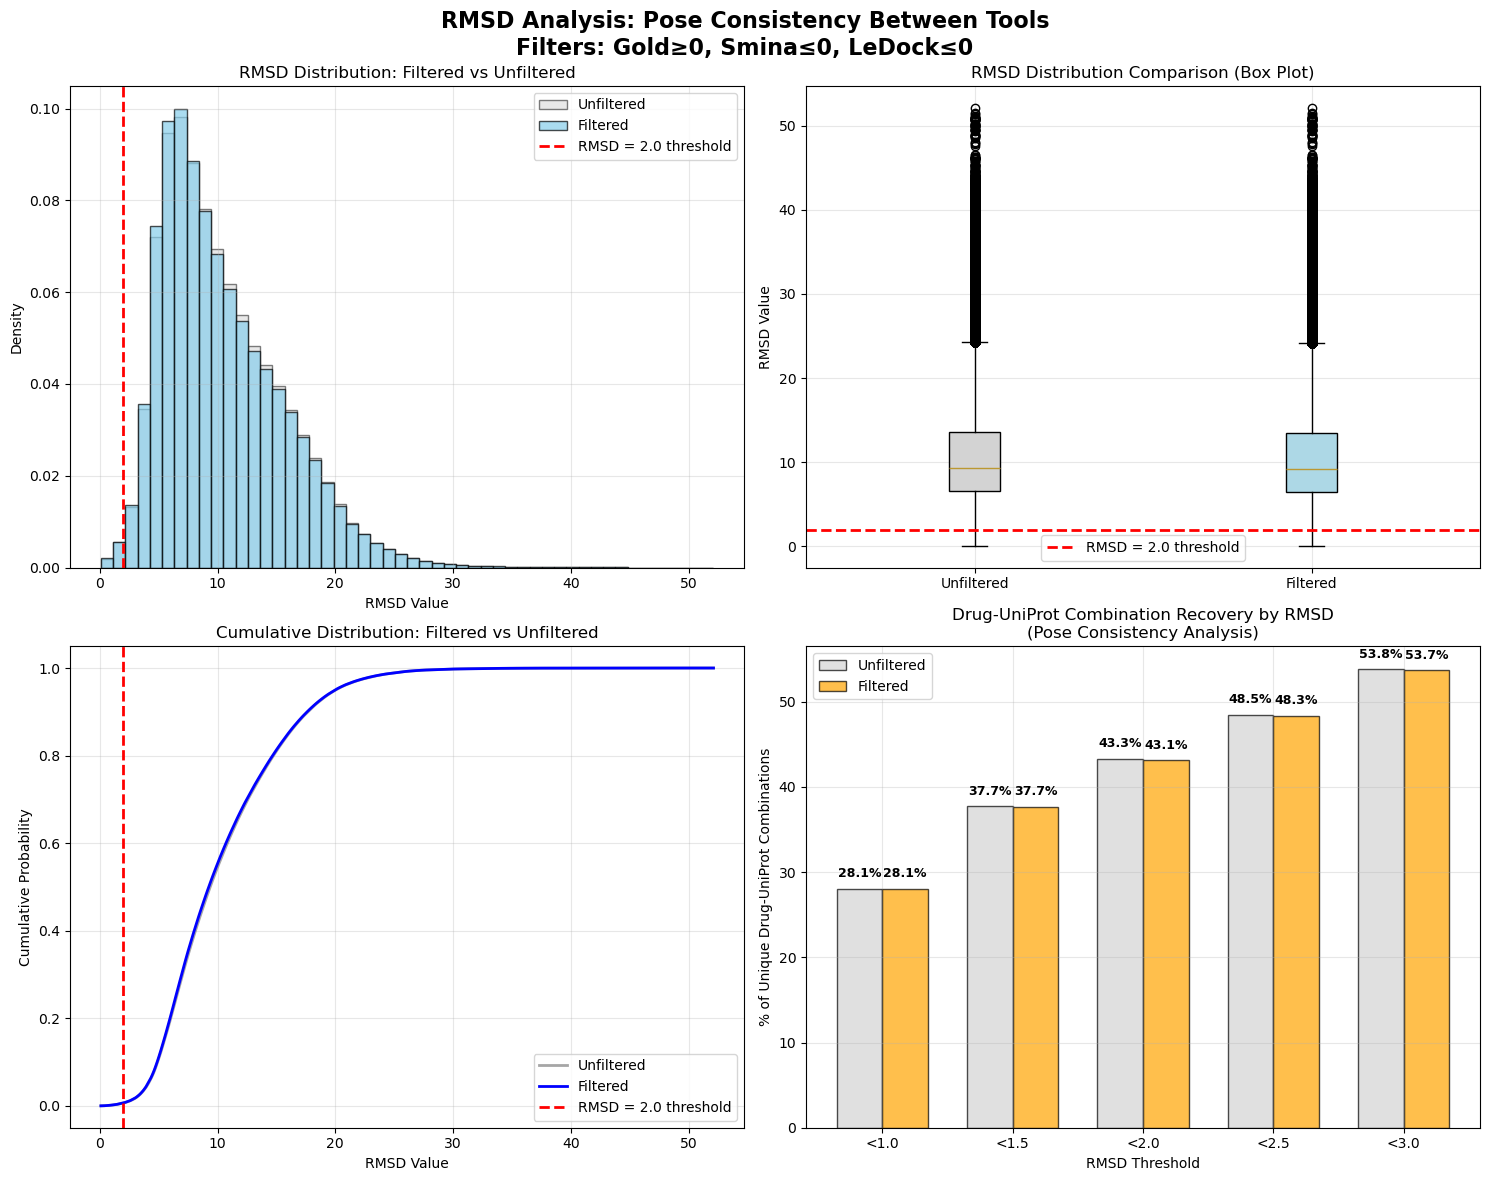


=== DRUG-UNIPROT COMBINATION RECOVERY ANALYSIS ===
This analysis shows what percentage of known drug-uniprot combinations
are recovered based on pose consistency (RMSD) between different tools.

Dataset      Total Combinations Description                                       
--------------------------------------------------------------------------------
Unfiltered   3,543              All drug-uniprot pairs in dataset                 
Filtered     3,542              Pairs meeting scoring criteria                    

=== COMBINATION RECOVERY BY RMSD THRESHOLD ===
RMSD     Unfiltered           Filtered             Improvement    
Thresh   Count (% of total)   Count (% of total)   (% points)     
---------------------------------------------------------------------------
<1.0     994 (28.1%)      994 (28.1%)      +0.0
<1.5     1,336 (37.7%)      1,334 (37.7%)      -0.0
<2.0     1,533 (43.3%)      1,528 (43.1%)      -0.1
<2.5     1,717 (48.5%)      1,712 (48.3%)      -0.1
<3.0     1,9

In [21]:
# RMSD Distribution Plots (with scoring cutoffs) - Focus on Unique Drug-UniProt Combinations

if not combined_results.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    # Convert filtered data to pandas for easier plotting
    rmsd_values_filtered = filtered_data.select([rmsd_col]).to_pandas()[rmsd_col]
    rmsd_values_unfiltered = combined_results.select([rmsd_col]).to_pandas()[rmsd_col]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'RMSD Analysis: Pose Consistency Between Tools\nFilters: Gold≥{GOLD_MIN_SCORE}, Smina≤{SMINA_MAX_SCORE}, LeDock≤{LEDOCK_MAX_SCORE}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Histogram comparison (filtered vs unfiltered)
    axes[0, 0].hist(rmsd_values_unfiltered, bins=50, alpha=0.5, color='lightgray', 
                    edgecolor='black', label='Unfiltered', density=True)
    axes[0, 0].hist(rmsd_values_filtered, bins=50, alpha=0.7, color='skyblue', 
                    edgecolor='black', label='Filtered', density=True)
    axes[0, 0].axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 0].set_xlabel('RMSD Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('RMSD Distribution: Filtered vs Unfiltered')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    box_data = [rmsd_values_unfiltered, rmsd_values_filtered]
    box_labels = ['Unfiltered', 'Filtered']
    bp = axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgray')
    bp['boxes'][1].set_facecolor('lightblue')
    axes[0, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 1].set_ylabel('RMSD Value')
    axes[0, 1].set_title('RMSD Distribution Comparison (Box Plot)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Cumulative distribution comparison
    sorted_rmsd_unfiltered = np.sort(rmsd_values_unfiltered)
    cumulative_unfiltered = np.arange(1, len(sorted_rmsd_unfiltered) + 1) / len(sorted_rmsd_unfiltered)
    sorted_rmsd_filtered = np.sort(rmsd_values_filtered)
    cumulative_filtered = np.arange(1, len(sorted_rmsd_filtered) + 1) / len(sorted_rmsd_filtered)
    
    axes[1, 0].plot(sorted_rmsd_unfiltered, cumulative_unfiltered, linewidth=2, 
                    color='gray', alpha=0.7, label='Unfiltered')
    axes[1, 0].plot(sorted_rmsd_filtered, cumulative_filtered, linewidth=2, 
                    color='blue', label='Filtered')
    axes[1, 0].axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[1, 0].set_xlabel('RMSD Value')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution: Filtered vs Unfiltered')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Drug-UniProt combination recovery by RMSD threshold (percentage plot)
    thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    # Calculate total unique combinations (for percentage calculation)
    total_combinations_filtered = analysis_data.select(['drugbank_id', 'uniprot_id']).unique().height
    total_combinations_unfiltered = combined_results.select(['drugbank_id', 'uniprot_id']).unique().height
    
    unique_combinations_filtered = []
    unique_combinations_unfiltered = []
    percentage_filtered = []
    percentage_unfiltered = []
    
    for threshold in thresholds:
        # Filtered data combinations below threshold
        unique_filtered = analysis_data.filter(pl.col(rmsd_col) < threshold).select(['drugbank_id', 'uniprot_id']).unique().height
        unique_combinations_filtered.append(unique_filtered)
        percentage_filtered.append((unique_filtered / total_combinations_filtered) * 100 if total_combinations_filtered > 0 else 0)
        
        # Unfiltered data combinations below threshold
        unique_unfiltered = combined_results.filter(pl.col(rmsd_col) < threshold).select(['drugbank_id', 'uniprot_id']).unique().height
        unique_combinations_unfiltered.append(unique_unfiltered)
        percentage_unfiltered.append((unique_unfiltered / total_combinations_unfiltered) * 100 if total_combinations_unfiltered > 0 else 0)
    
    # Create bar chart showing percentages
    x_pos = np.arange(len(thresholds))
    width = 0.35
    
    bars1 = axes[1, 1].bar(x_pos - width/2, percentage_unfiltered, width, alpha=0.7, color='lightgray', 
                          edgecolor='black', label='Unfiltered')
    bars2 = axes[1, 1].bar(x_pos + width/2, percentage_filtered, width, alpha=0.7, color='orange', 
                          edgecolor='black', label='Filtered')
    
    axes[1, 1].set_xlabel('RMSD Threshold')
    axes[1, 1].set_ylabel('% of Unique Drug-UniProt Combinations')
    axes[1, 1].set_title('Drug-UniProt Combination Recovery by RMSD\n(Pose Consistency Analysis)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f'<{t}' for t in thresholds])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, percentage_unfiltered):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    for bar, value in zip(bars2, percentage_filtered):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed combination statistics comparison
    print(f"\n=== DRUG-UNIPROT COMBINATION RECOVERY ANALYSIS ===")
    print(f"This analysis shows what percentage of known drug-uniprot combinations")
    print(f"are recovered based on pose consistency (RMSD) between different tools.\n")
    
    print(f"{'Dataset':<12} {'Total Combinations':<18} {'Description':<50}")
    print("-" * 80)
    print(f"{'Unfiltered':<12} {total_combinations_unfiltered:<18,} {'All drug-uniprot pairs in dataset':<50}")
    print(f"{'Filtered':<12} {total_combinations_filtered:<18,} {'Pairs meeting scoring criteria':<50}")
    
    print(f"\n=== COMBINATION RECOVERY BY RMSD THRESHOLD ===")
    print(f"{'RMSD':<8} {'Unfiltered':<20} {'Filtered':<20} {'Improvement':<15}")
    print(f"{'Thresh':<8} {'Count (% of total)':<20} {'Count (% of total)':<20} {'(% points)':<15}")
    print("-" * 75)
    
    for i, threshold in enumerate(thresholds):
        unf_count = unique_combinations_unfiltered[i]
        unf_pct = percentage_unfiltered[i]
        filt_count = unique_combinations_filtered[i]
        filt_pct = percentage_filtered[i]
        improvement = filt_pct - unf_pct
        
        print(f"{'<' + str(threshold):<8} {unf_count:,} ({unf_pct:.1f}%){'':<5} {filt_count:,} ({filt_pct:.1f}%){'':<5} {improvement:+.1f}")
    
    # Calculate unique combination statistics for key thresholds
    print(f"\n=== KEY POSE CONSISTENCY METRICS ===")
    
    # RMSD < 2.0 analysis (most important threshold)
    unf_good_combinations = combined_results.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    filt_good_combinations = analysis_data.filter(pl.col(rmsd_col) < 2.0).select(['drugbank_id', 'uniprot_id']).unique().height
    
    unf_good_percentage = (unf_good_combinations / total_combinations_unfiltered) * 100 if total_combinations_unfiltered > 0 else 0
    filt_good_percentage = (filt_good_combinations / total_combinations_filtered) * 100 if total_combinations_filtered > 0 else 0
    
    print(f"RMSD < 2.0 (Good Pose Consistency):")
    print(f"  Unfiltered: {unf_good_combinations:,} / {total_combinations_unfiltered:,} combinations ({unf_good_percentage:.1f}%)")
    print(f"  Filtered:   {filt_good_combinations:,} / {total_combinations_filtered:,} combinations ({filt_good_percentage:.1f}%)")
    print(f"  Improvement: {filt_good_percentage - unf_good_percentage:+.1f} percentage points")
    
    # RMSD < 1.5 analysis (excellent consistency)
    unf_excellent_combinations = combined_results.filter(pl.col(rmsd_col) < 1.5).select(['drugbank_id', 'uniprot_id']).unique().height
    filt_excellent_combinations = analysis_data.filter(pl.col(rmsd_col) < 1.5).select(['drugbank_id', 'uniprot_id']).unique().height
    
    unf_excellent_percentage = (unf_excellent_combinations / total_combinations_unfiltered) * 100 if total_combinations_unfiltered > 0 else 0
    filt_excellent_percentage = (filt_excellent_combinations / total_combinations_filtered) * 100 if total_combinations_filtered > 0 else 0
    
    print(f"\nRMSD < 1.5 (Excellent Pose Consistency):")
    print(f"  Unfiltered: {unf_excellent_combinations:,} / {total_combinations_unfiltered:,} combinations ({unf_excellent_percentage:.1f}%)")
    print(f"  Filtered:   {filt_excellent_combinations:,} / {total_combinations_filtered:,} combinations ({filt_excellent_percentage:.1f}%)")
    print(f"  Improvement: {filt_excellent_percentage - unf_excellent_percentage:+.1f} percentage points")
    
    print(f"\n💡 Interpretation:")
    print(f"   • Higher percentages indicate better pose consistency between docking tools")
    print(f"   • Filtering by scoring criteria {'improves' if filt_good_percentage > unf_good_percentage else 'reduces'} pose consistency")
    print(f"   • {filt_good_percentage:.1f}% of filtered combinations show good pose agreement (RMSD < 2.0)")
    
elif not combined_results.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the cell with scoring cutoffs first.")
else:
    print("No RMSD data available for plotting.")

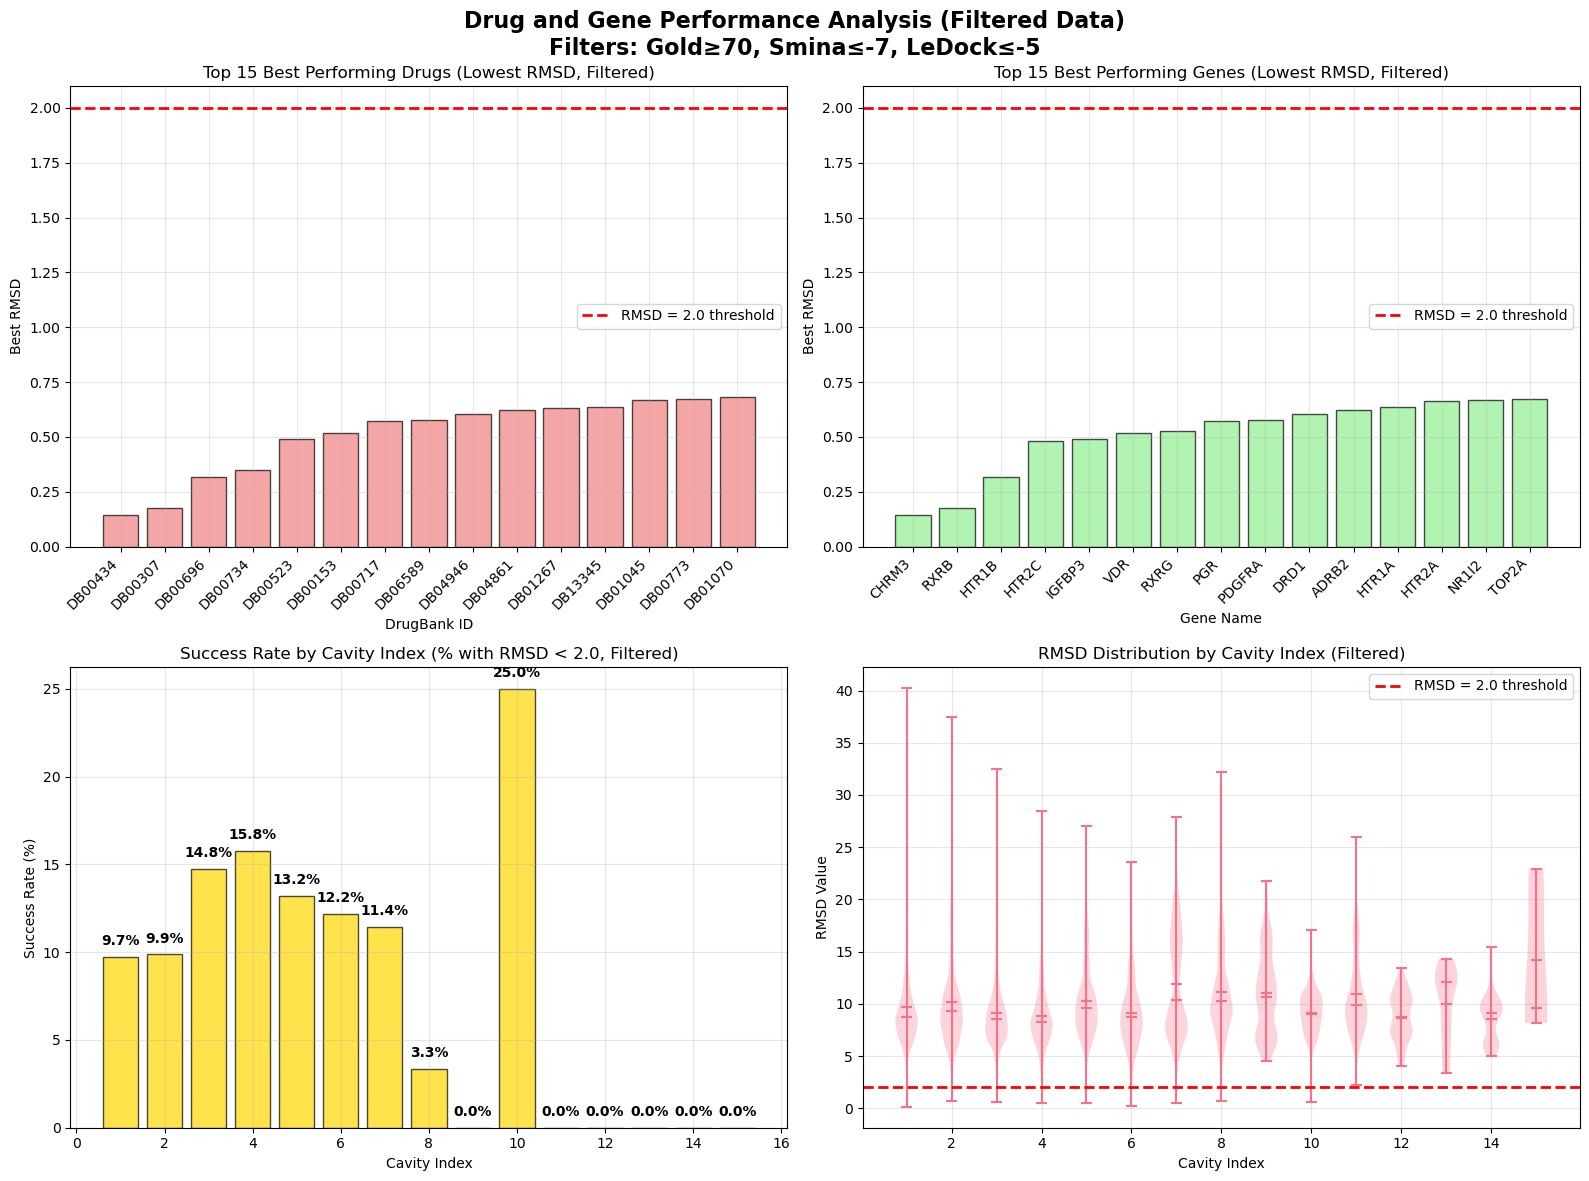


=== PERFORMANCE INSIGHTS (FILTERED DATA) ===
Best performing drug: DB00434 (RMSD: 0.144)
Best performing gene: CHRM3 (RMSD: 0.144)
Best cavity index: 10 (25.0% success rate)

=== FILTERING IMPACT ON PERFORMANCE ===
Drugs with data: 973 -> 15 (retained 1.5%)
Drugs with data: 973 -> 15 (retained 1.5%)
Genes with data: 908 -> 15 (retained 1.7%)
Genes with data: 908 -> 15 (retained 1.7%)


In [13]:
# Drug and Gene Performance Analysis Plots (with scoring cutoffs)

if not combined_results.is_empty() and rmsd_columns and 'filtered_data' in globals():
    rmsd_col = rmsd_columns[0]
    
    # Convert filtered data to pandas only for plotting (minimal usage)
    plot_data = filtered_data.to_pandas()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Drug and Gene Performance Analysis (Filtered Data)\nFilters: Gold≥{GOLD_MIN_SCORE}, Smina≤{SMINA_MAX_SCORE}, LeDock≤{LEDOCK_MAX_SCORE}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Top 15 best performing drugs (by minimum RMSD) - filtered data
    drug_performance = plot_data.groupby('drugbank_id')[rmsd_col].agg(['min', 'mean', 'count']).reset_index()
    drug_performance = drug_performance.sort_values('min').head(15)
    
    bars1 = axes[0, 0].bar(range(len(drug_performance)), drug_performance['min'], 
                           alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 0].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 0].set_xlabel('DrugBank ID')
    axes[0, 0].set_ylabel('Best RMSD')
    axes[0, 0].set_title('Top 15 Best Performing Drugs (Lowest RMSD, Filtered)')
    axes[0, 0].set_xticks(range(len(drug_performance)))
    axes[0, 0].set_xticklabels(drug_performance['drugbank_id'], rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top 15 best performing genes (by minimum RMSD) - filtered data
    gene_performance = plot_data.groupby('gene_name')[rmsd_col].agg(['min', 'mean', 'count']).reset_index()
    gene_performance = gene_performance.sort_values('min').head(15)
    
    bars2 = axes[0, 1].bar(range(len(gene_performance)), gene_performance['min'], 
                           alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
    axes[0, 1].set_xlabel('Gene Name')
    axes[0, 1].set_ylabel('Best RMSD')
    axes[0, 1].set_title('Top 15 Best Performing Genes (Lowest RMSD, Filtered)')
    axes[0, 1].set_xticks(range(len(gene_performance)))
    axes[0, 1].set_xticklabels(gene_performance['gene_name'], rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Success rate by cavity index - filtered data
    cavity_success = plot_data.groupby('cavity_index').apply(
        lambda x: pd.Series({
            'total_combinations': len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()),
            'good_combinations': len(x[x[rmsd_col] < 2.0][['drugbank_id', 'uniprot_id']].drop_duplicates()),
            'success_rate': len(x[x[rmsd_col] < 2.0][['drugbank_id', 'uniprot_id']].drop_duplicates()) / len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()) * 100 if len(x[['drugbank_id', 'uniprot_id']].drop_duplicates()) > 0 else 0
        })
    ).reset_index()
    
    bars3 = axes[1, 0].bar(cavity_success['cavity_index'], cavity_success['success_rate'], 
                           alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_xlabel('Cavity Index')
    axes[1, 0].set_ylabel('Success Rate (%)')
    axes[1, 0].set_title('Success Rate by Cavity Index (% with RMSD < 2.0, Filtered)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars3, cavity_success['success_rate']):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. RMSD distribution by cavity index (violin plot) - filtered data
    cavity_indices = sorted(plot_data['cavity_index'].unique())
    cavity_data = [plot_data[plot_data['cavity_index'] == i][rmsd_col].values 
                   for i in cavity_indices]
    
    # Only plot cavities that have data
    valid_indices = []
    valid_data = []
    for i, data in enumerate(cavity_data):
        if len(data) > 0:
            valid_indices.append(cavity_indices[i])
            valid_data.append(data)
    
    if valid_data:
        parts = axes[1, 1].violinplot(valid_data, positions=valid_indices, 
                                      showmeans=True, showmedians=True)
        axes[1, 1].axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='RMSD = 2.0 threshold')
        axes[1, 1].set_xlabel('Cavity Index')
        axes[1, 1].set_ylabel('RMSD Value')
        axes[1, 1].set_title('RMSD Distribution by Cavity Index (Filtered)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No data available\nafter filtering', 
                        ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].set_title('RMSD Distribution by Cavity Index (Filtered)')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print(f"\n=== PERFORMANCE INSIGHTS (FILTERED DATA) ===")
    if len(drug_performance) > 0:
        print(f"Best performing drug: {drug_performance.iloc[0]['drugbank_id']} (RMSD: {drug_performance.iloc[0]['min']:.3f})")
    if len(gene_performance) > 0:
        print(f"Best performing gene: {gene_performance.iloc[0]['gene_name']} (RMSD: {gene_performance.iloc[0]['min']:.3f})")
    if len(cavity_success) > 0 and cavity_success['success_rate'].max() > 0:
        best_cavity_idx = cavity_success.loc[cavity_success['success_rate'].idxmax(), 'cavity_index']
        best_cavity_rate = cavity_success['success_rate'].max()
        print(f"Best cavity index: {best_cavity_idx} ({best_cavity_rate:.1f}% success rate)")
    
    # Compare with unfiltered data
    print(f"\n=== FILTERING IMPACT ON PERFORMANCE ===")
    unfiltered_plot_data = combined_results.to_pandas()
    
    # Drug comparison
    unfiltered_drug_perf = unfiltered_plot_data.groupby('drugbank_id')[rmsd_col].agg(['min']).reset_index()
    filtered_drug_count = len(drug_performance)
    unfiltered_drug_count = len(unfiltered_drug_perf)
    print(f"Drugs with data: {unfiltered_drug_count} -> {filtered_drug_count} (retained {(filtered_drug_count/unfiltered_drug_count)*100:.1f}%)")
    
    # Gene comparison
    unfiltered_gene_perf = unfiltered_plot_data.groupby('gene_name')[rmsd_col].agg(['min']).reset_index()
    filtered_gene_count = len(gene_performance)
    unfiltered_gene_count = len(unfiltered_gene_perf)
    print(f"Genes with data: {unfiltered_gene_count} -> {filtered_gene_count} (retained {(filtered_gene_count/unfiltered_gene_count)*100:.1f}%)")
    
elif not combined_results.is_empty() and rmsd_columns:
    print("Warning: Filtered data not available. Please run the cell with scoring cutoffs first.")
else:
    print("No RMSD data available for plotting.")

=== SCORE DISTRIBUTIONS ANALYSIS ===
Processing Tool1/Score1 data...
  GOLD (Tool1): 3,476 unique drug-uniprot combinations
  GOLD (Tool1): 3,476 unique drug-uniprot combinations
  LEDOCK (Tool1): 1,702 unique drug-uniprot combinations
Processing Tool2/Score2 data...
  LEDOCK (Tool1): 1,702 unique drug-uniprot combinations
Processing Tool2/Score2 data...
  GOLD (Tool2): 1,614 unique drug-uniprot combinations
  GOLD (Tool2): 1,614 unique drug-uniprot combinations
  SMINA (Tool2): 3,543 unique drug-uniprot combinations
  SMINA (Tool2): 3,543 unique drug-uniprot combinations

Generating score distribution plots...

Generating score distribution plots...


/tmp/ipykernel_1722108/4054086985.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)


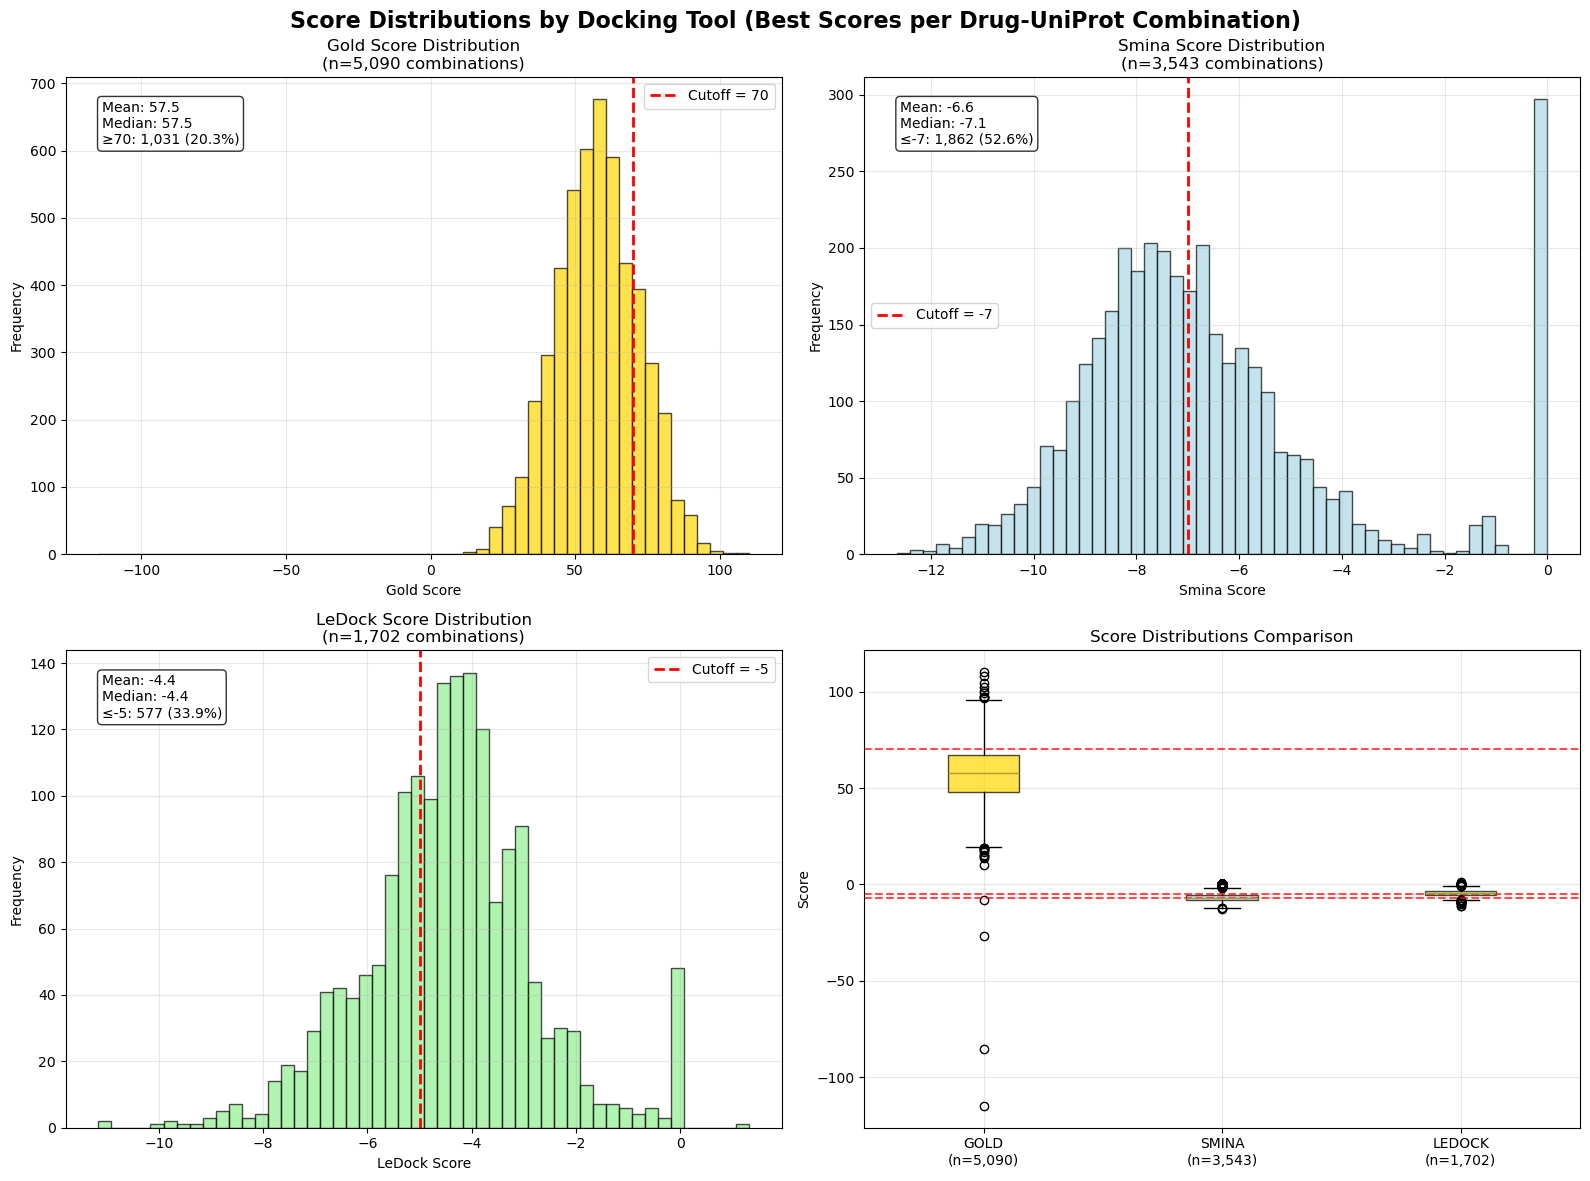


=== SCORE DISTRIBUTION SUMMARY ===

GOLD:
  Unique combinations: 5,090
  Mean score: 57.462
  Median score: 57.540
  Min score: -114.880
  Max score: 110.190
  Std deviation: 14.713
  Above cutoff (≥70): 1,031 (20.3%)

SMINA:
  Unique combinations: 3,543
  Mean score: -6.584
  Median score: -7.133
  Min score: -12.662
  Max score: 0.000
  Std deviation: 2.653
  Below cutoff (≤-7): 1,862 (52.6%)

LEDOCK:
  Unique combinations: 1,702
  Mean score: -4.433
  Median score: -4.410
  Min score: -11.160
  Max score: 1.320
  Std deviation: 1.647
  Below cutoff (≤-5): 577 (33.9%)


In [15]:
# Score Distributions Analysis (Best Scores per Drug-UniProt Combination)

if not combined_results.is_empty():
    print("=== SCORE DISTRIBUTIONS ANALYSIS ===")
    
    # Check if we have Tool and Score columns
    has_tool1 = 'Tool1' in combined_results.columns
    has_tool2 = 'Tool2' in combined_results.columns
    has_score1 = 'Score1' in combined_results.columns
    has_score2 = 'Score2' in combined_results.columns
    
    if (has_tool1 and has_score1) or (has_tool2 and has_score2):
        # Create figure for score distributions
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Score Distributions by Docking Tool (Best Scores per Drug-UniProt Combination)', 
                     fontsize=16, fontweight='bold')
        
        tool_data = {}
        
        # Process Tool1/Score1 data
        if has_tool1 and has_score1:
            print("Processing Tool1/Score1 data...")
            
            # Get best scores for each drug-uniprot combination by tool
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                tool_subset = combined_results.filter(
                    pl.col('Tool1').str.to_uppercase().str.contains(tool_name)
                )
                
                if tool_subset.height > 0:
                    if tool_name == 'GOLD':
                        # For Gold, best = maximum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score1').max().alias('best_score')
                        )
                    else:
                        # For Smina and LeDock, best = minimum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score1').min().alias('best_score')
                        )
                    
                    if best_scores.height > 0:
                        scores = best_scores.select('best_score').to_pandas()['best_score'].values
                        tool_data[f'{tool_name}_Tool1'] = scores
                        print(f"  {tool_name} (Tool1): {len(scores):,} unique drug-uniprot combinations")
        
        # Process Tool2/Score2 data
        if has_tool2 and has_score2:
            print("Processing Tool2/Score2 data...")
            
            # Get best scores for each drug-uniprot combination by tool
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                tool_subset = combined_results.filter(
                    pl.col('Tool2').str.to_uppercase().str.contains(tool_name)
                )
                
                if tool_subset.height > 0:
                    if tool_name == 'GOLD':
                        # For Gold, best = maximum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score2').max().alias('best_score')
                        )
                    else:
                        # For Smina and LeDock, best = minimum score
                        best_scores = tool_subset.group_by(['drugbank_id', 'uniprot_id']).agg(
                            pl.col('Score2').min().alias('best_score')
                        )
                    
                    if best_scores.height > 0:
                        scores = best_scores.select('best_score').to_pandas()['best_score'].values
                        tool_data[f'{tool_name}_Tool2'] = scores
                        print(f"  {tool_name} (Tool2): {len(scores):,} unique drug-uniprot combinations")
        
        # Plot distributions
        if tool_data:
            print(f"\nGenerating score distribution plots...")
            
            # Combine Tool1 and Tool2 data for each tool type
            combined_tool_data = {}
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                all_scores = []
                if f'{tool_name}_Tool1' in tool_data:
                    all_scores.extend(tool_data[f'{tool_name}_Tool1'])
                if f'{tool_name}_Tool2' in tool_data:
                    all_scores.extend(tool_data[f'{tool_name}_Tool2'])
                
                if all_scores:
                    combined_tool_data[tool_name] = np.array(all_scores)
            
            # Plot 1: Gold score distribution
            if 'GOLD' in combined_tool_data:
                gold_scores = combined_tool_data['GOLD']
                axes[0, 0].hist(gold_scores, bins=50, alpha=0.7, color='gold', edgecolor='black')
                axes[0, 0].axvline(x=GOLD_MIN_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {GOLD_MIN_SCORE}')
                axes[0, 0].set_xlabel('Gold Score')
                axes[0, 0].set_ylabel('Frequency')
                axes[0, 0].set_title(f'Gold Score Distribution\n(n={len(gold_scores):,} combinations)')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = gold_scores.mean()
                median_score = np.median(gold_scores)
                above_cutoff = (gold_scores >= GOLD_MIN_SCORE).sum()
                axes[0, 0].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≥{GOLD_MIN_SCORE}: {above_cutoff:,} ({above_cutoff/len(gold_scores)*100:.1f}%)', 
                               transform=axes[0, 0].transAxes, verticalalignment='top', 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[0, 0].text(0.5, 0.5, 'No Gold data available', ha='center', va='center', 
                               transform=axes[0, 0].transAxes, fontsize=14)
                axes[0, 0].set_title('Gold Score Distribution')
            
            # Plot 2: Smina score distribution  
            if 'SMINA' in combined_tool_data:
                smina_scores = combined_tool_data['SMINA']
                axes[0, 1].hist(smina_scores, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
                axes[0, 1].axvline(x=SMINA_MAX_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {SMINA_MAX_SCORE}')
                axes[0, 1].set_xlabel('Smina Score')
                axes[0, 1].set_ylabel('Frequency')
                axes[0, 1].set_title(f'Smina Score Distribution\n(n={len(smina_scores):,} combinations)')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = smina_scores.mean()
                median_score = np.median(smina_scores)
                below_cutoff = (smina_scores <= SMINA_MAX_SCORE).sum()
                axes[0, 1].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≤{SMINA_MAX_SCORE}: {below_cutoff:,} ({below_cutoff/len(smina_scores)*100:.1f}%)', 
                               transform=axes[0, 1].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[0, 1].text(0.5, 0.5, 'No Smina data available', ha='center', va='center', 
                               transform=axes[0, 1].transAxes, fontsize=14)
                axes[0, 1].set_title('Smina Score Distribution')
            
            # Plot 3: LeDock score distribution
            if 'LEDOCK' in combined_tool_data:
                ledock_scores = combined_tool_data['LEDOCK']
                axes[1, 0].hist(ledock_scores, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
                axes[1, 0].axvline(x=LEDOCK_MAX_SCORE, color='red', linestyle='--', linewidth=2, 
                                  label=f'Cutoff = {LEDOCK_MAX_SCORE}')
                axes[1, 0].set_xlabel('LeDock Score')
                axes[1, 0].set_ylabel('Frequency')
                axes[1, 0].set_title(f'LeDock Score Distribution\n(n={len(ledock_scores):,} combinations)')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
                
                # Add statistics
                mean_score = ledock_scores.mean()
                median_score = np.median(ledock_scores)
                below_cutoff = (ledock_scores <= LEDOCK_MAX_SCORE).sum()
                axes[1, 0].text(0.05, 0.95, f'Mean: {mean_score:.1f}\nMedian: {median_score:.1f}\n≤{LEDOCK_MAX_SCORE}: {below_cutoff:,} ({below_cutoff/len(ledock_scores)*100:.1f}%)', 
                               transform=axes[1, 0].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                axes[1, 0].text(0.5, 0.5, 'No LeDock data available', ha='center', va='center', 
                               transform=axes[1, 0].transAxes, fontsize=14)
                axes[1, 0].set_title('LeDock Score Distribution')
            
            # Plot 4: Combined box plot
            box_data = []
            box_labels = []
            colors = []
            
            for tool_name, color in [('GOLD', 'gold'), ('SMINA', 'lightblue'), ('LEDOCK', 'lightgreen')]:
                if tool_name in combined_tool_data:
                    box_data.append(combined_tool_data[tool_name])
                    box_labels.append(f'{tool_name}\n(n={len(combined_tool_data[tool_name]):,})')
                    colors.append(color)
            
            if box_data:
                bp = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
                
                # Color the boxes
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                # Add cutoff lines
                if 'GOLD' in combined_tool_data:
                    axes[1, 1].axhline(y=GOLD_MIN_SCORE, color='red', linestyle='--', alpha=0.7)
                if 'SMINA' in combined_tool_data:
                    axes[1, 1].axhline(y=SMINA_MAX_SCORE, color='red', linestyle='--', alpha=0.7)
                if 'LEDOCK' in combined_tool_data:
                    axes[1, 1].axhline(y=LEDOCK_MAX_SCORE, color='red', linestyle='--', alpha=0.7)
                
                axes[1, 1].set_ylabel('Score')
                axes[1, 1].set_title('Score Distributions Comparison')
                axes[1, 1].grid(True, alpha=0.3)
            else:
                axes[1, 1].text(0.5, 0.5, 'No scoring data available', ha='center', va='center', 
                               transform=axes[1, 1].transAxes, fontsize=14)
                axes[1, 1].set_title('Score Distributions Comparison')
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\n=== SCORE DISTRIBUTION SUMMARY ===")
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name in combined_tool_data:
                    scores = combined_tool_data[tool_name]
                    print(f"\n{tool_name}:")
                    print(f"  Unique combinations: {len(scores):,}")
                    print(f"  Mean score: {scores.mean():.3f}")
                    print(f"  Median score: {np.median(scores):.3f}")
                    print(f"  Min score: {scores.min():.3f}")
                    print(f"  Max score: {scores.max():.3f}")
                    print(f"  Std deviation: {scores.std():.3f}")
                    
                    if tool_name == 'GOLD':
                        above_cutoff = (scores >= GOLD_MIN_SCORE).sum()
                        print(f"  Above cutoff (≥{GOLD_MIN_SCORE}): {above_cutoff:,} ({above_cutoff/len(scores)*100:.1f}%)")
                    else:
                        cutoff = SMINA_MAX_SCORE if tool_name == 'SMINA' else LEDOCK_MAX_SCORE
                        below_cutoff = (scores <= cutoff).sum()
                        print(f"  Below cutoff (≤{cutoff}): {below_cutoff:,} ({below_cutoff/len(scores)*100:.1f}%)")
        
        else:
            print("No tool/score data found for distribution analysis.")
    
    else:
        print("No Tool/Score columns found in the dataset.")

else:
    print("No data available for score distribution analysis.")

=== TOOL COVERAGE ANALYSIS ===
Processing Tool1/Score1 data...
Processing Tool2/Score2 data...
Processing Tool2/Score2 data...

=== TOOL COVERAGE RESULTS ===
Individual tool coverage:
  GOLD: 3,476 unique drug-uniprot combinations
  SMINA: 3,543 unique drug-uniprot combinations
  LEDOCK: 1,702 unique drug-uniprot combinations

Combinations with ALL three tools (Gold AND Smina AND LeDock): 1,635
Combinations with ANY tool (Gold OR Smina OR LeDock): 3,543

Pairwise overlaps:
  Gold AND Smina: 3,476
  Gold AND LeDock: 1,635
  Smina AND LeDock: 1,702

Tool-specific combinations (only one tool):
  Only Gold: 0
  Only Smina: 0
  Only LeDock: 0

=== TOOL COVERAGE RESULTS ===
Individual tool coverage:
  GOLD: 3,476 unique drug-uniprot combinations
  SMINA: 3,543 unique drug-uniprot combinations
  LEDOCK: 1,702 unique drug-uniprot combinations

Combinations with ALL three tools (Gold AND Smina AND LeDock): 1,635
Combinations with ANY tool (Gold OR Smina OR LeDock): 3,543

Pairwise overlaps:
  G

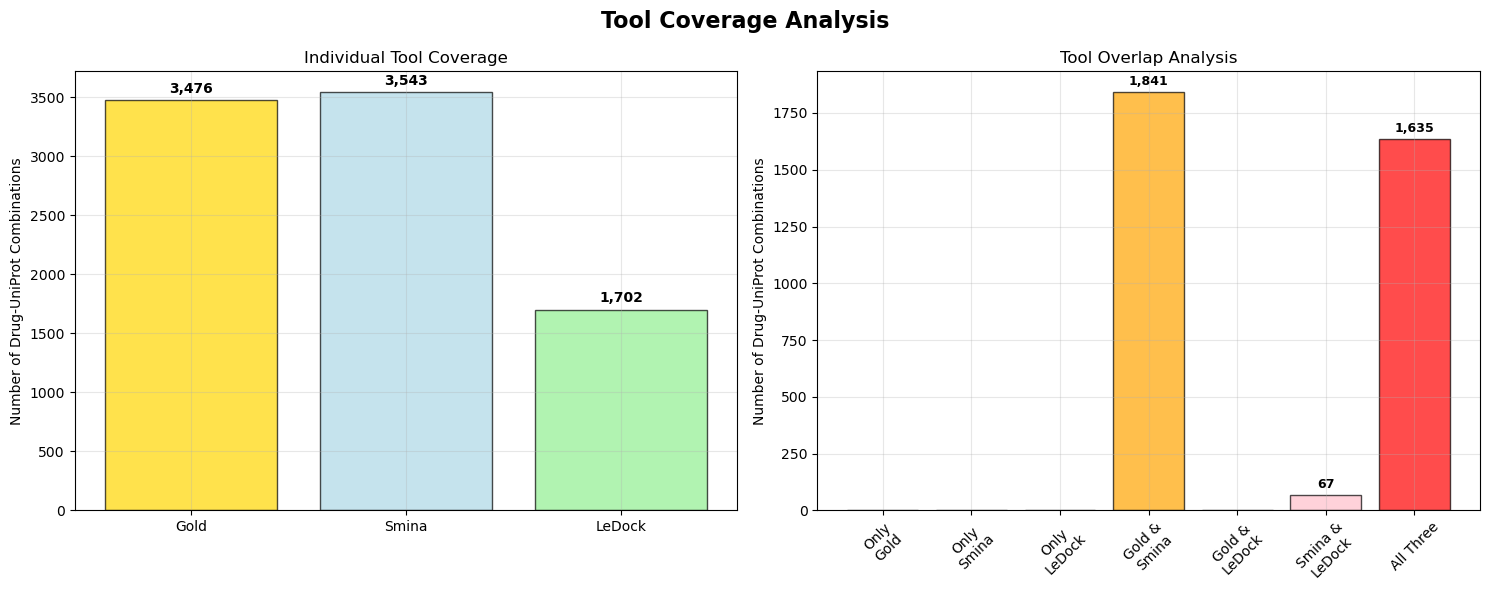


=== COVERAGE PERCENTAGES ===
Total unique drug-uniprot combinations in dataset: 3,543
  GOLD coverage: 98.1%
  SMINA coverage: 100.0%
  LEDOCK coverage: 48.0%
  ANY tool coverage: 100.0%
  ALL tools coverage: 46.1%

=== SUMMARY TABLE ===
Category                  Count      Percentage  
-----------------------------------------------
Total combinations        3,543      100.0%      
Gold only                 3,476      98.1        %
Smina only                3,543      100.0       %
LeDock only               1,702      48.0        %
Any tool (OR)             3,543      100.0       %
All tools (AND)           1,635      46.1        %


In [16]:
# Tool Coverage Analysis - Drug-UniProt Combinations by Tool

if not combined_results.is_empty():
    print("=== TOOL COVERAGE ANALYSIS ===")
    
    # Check if we have Tool and Score columns
    has_tool1 = 'Tool1' in combined_results.columns
    has_tool2 = 'Tool2' in combined_results.columns
    has_score1 = 'Score1' in combined_results.columns
    has_score2 = 'Score2' in combined_results.columns
    
    if (has_tool1 and has_score1) or (has_tool2 and has_score2):
        
        # Collect all drug-uniprot combinations for each tool
        tool_combinations = {
            'GOLD': set(),
            'SMINA': set(), 
            'LEDOCK': set()
        }
        
        # Process Tool1/Score1 data
        if has_tool1 and has_score1:
            print("Processing Tool1/Score1 data...")
            
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name == 'LEDOCK':
                    # Check for both LEDOCK and LEDOCK variations
                    tool_subset = combined_results.filter(
                        pl.col('Tool1').str.to_uppercase().str.contains('LEDOCK')
                    )
                else:
                    tool_subset = combined_results.filter(
                        pl.col('Tool1').str.to_uppercase() == tool_name
                    )
                
                if tool_subset.height > 0:
                    combinations = tool_subset.select(['drugbank_id', 'uniprot_id']).unique()
                    for row in combinations.iter_rows():
                        tool_combinations[tool_name].add((row[0], row[1]))
        
        # Process Tool2/Score2 data
        if has_tool2 and has_score2:
            print("Processing Tool2/Score2 data...")
            
            for tool_name in ['GOLD', 'SMINA', 'LEDOCK']:
                if tool_name == 'LEDOCK':
                    # Check for both LEDOCK and LEDOCK variations
                    tool_subset = combined_results.filter(
                        pl.col('Tool2').str.to_uppercase().str.contains('LEDOCK')
                    )
                else:
                    tool_subset = combined_results.filter(
                        pl.col('Tool2').str.to_uppercase() == tool_name
                    )
                
                if tool_subset.height > 0:
                    combinations = tool_subset.select(['drugbank_id', 'uniprot_id']).unique()
                    for row in combinations.iter_rows():
                        tool_combinations[tool_name].add((row[0], row[1]))
        
        # Calculate overlaps and coverage
        print(f"\n=== TOOL COVERAGE RESULTS ===")
        print(f"Individual tool coverage:")
        for tool_name, combinations in tool_combinations.items():
            print(f"  {tool_name}: {len(combinations):,} unique drug-uniprot combinations")
        
        # Calculate combinations with all three tools
        all_tools = tool_combinations['GOLD'] & tool_combinations['SMINA'] & tool_combinations['LEDOCK']
        print(f"\nCombinations with ALL three tools (Gold AND Smina AND LeDock): {len(all_tools):,}")
        
        # Calculate combinations with at least one tool
        any_tool = tool_combinations['GOLD'] | tool_combinations['SMINA'] | tool_combinations['LEDOCK']
        print(f"Combinations with ANY tool (Gold OR Smina OR LeDock): {len(any_tool):,}")
        
        # Calculate pairwise overlaps
        print(f"\nPairwise overlaps:")
        gold_smina = tool_combinations['GOLD'] & tool_combinations['SMINA']
        gold_ledock = tool_combinations['GOLD'] & tool_combinations['LEDOCK']
        smina_ledock = tool_combinations['SMINA'] & tool_combinations['LEDOCK']
        
        print(f"  Gold AND Smina: {len(gold_smina):,}")
        print(f"  Gold AND LeDock: {len(gold_ledock):,}")
        print(f"  Smina AND LeDock: {len(smina_ledock):,}")
        
        # Calculate tool-specific combinations (only one tool)
        print(f"\nTool-specific combinations (only one tool):")
        only_gold = tool_combinations['GOLD'] - tool_combinations['SMINA'] - tool_combinations['LEDOCK']
        only_smina = tool_combinations['SMINA'] - tool_combinations['GOLD'] - tool_combinations['LEDOCK']
        only_ledock = tool_combinations['LEDOCK'] - tool_combinations['GOLD'] - tool_combinations['SMINA']
        
        print(f"  Only Gold: {len(only_gold):,}")
        print(f"  Only Smina: {len(only_smina):,}")
        print(f"  Only LeDock: {len(only_ledock):,}")
        
        # Create a coverage visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Tool Coverage Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Individual tool coverage
        tools = ['Gold', 'Smina', 'LeDock']
        counts = [len(tool_combinations['GOLD']), len(tool_combinations['SMINA']), len(tool_combinations['LEDOCK'])]
        colors = ['gold', 'lightblue', 'lightgreen']
        
        bars1 = axes[0].bar(tools, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_ylabel('Number of Drug-UniProt Combinations')
        axes[0].set_title('Individual Tool Coverage')
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars1, counts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                        f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Overlap analysis
        overlap_categories = ['Only\nGold', 'Only\nSmina', 'Only\nLeDock', 
                             'Gold &\nSmina', 'Gold &\nLeDock', 'Smina &\nLeDock', 
                             'All Three']
        overlap_counts = [len(only_gold), len(only_smina), len(only_ledock),
                         len(gold_smina) - len(all_tools), 
                         len(gold_ledock) - len(all_tools),
                         len(smina_ledock) - len(all_tools),
                         len(all_tools)]
        overlap_colors = ['gold', 'lightblue', 'lightgreen', 'orange', 'yellow', 'pink', 'red']
        
        bars2 = axes[1].bar(overlap_categories, overlap_counts, color=overlap_colors, alpha=0.7, edgecolor='black')
        axes[1].set_ylabel('Number of Drug-UniProt Combinations')
        axes[1].set_title('Tool Overlap Analysis')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars2, overlap_counts):
            if count > 0:
                axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(overlap_counts)*0.01,
                            f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate percentages
        total_combinations = combined_results.select(['drugbank_id', 'uniprot_id']).unique().height
        print(f"\n=== COVERAGE PERCENTAGES ===")
        print(f"Total unique drug-uniprot combinations in dataset: {total_combinations:,}")
        
        for tool_name, combinations in tool_combinations.items():
            percentage = (len(combinations) / total_combinations) * 100 if total_combinations > 0 else 0
            print(f"  {tool_name} coverage: {percentage:.1f}%")
        
        any_tool_percentage = (len(any_tool) / total_combinations) * 100 if total_combinations > 0 else 0
        all_tools_percentage = (len(all_tools) / total_combinations) * 100 if total_combinations > 0 else 0
        
        print(f"  ANY tool coverage: {any_tool_percentage:.1f}%")
        print(f"  ALL tools coverage: {all_tools_percentage:.1f}%")
        
        # Summary table
        print(f"\n=== SUMMARY TABLE ===")
        print(f"{'Category':<25} {'Count':<10} {'Percentage':<12}")
        print("-" * 47)
        print(f"{'Total combinations':<25} {total_combinations:<10,} {'100.0%':<12}")
        print(f"{'Gold only':<25} {len(tool_combinations['GOLD']):<10,} {(len(tool_combinations['GOLD'])/total_combinations)*100:<12.1f}%")
        print(f"{'Smina only':<25} {len(tool_combinations['SMINA']):<10,} {(len(tool_combinations['SMINA'])/total_combinations)*100:<12.1f}%")
        print(f"{'LeDock only':<25} {len(tool_combinations['LEDOCK']):<10,} {(len(tool_combinations['LEDOCK'])/total_combinations)*100:<12.1f}%")
        print(f"{'Any tool (OR)':<25} {len(any_tool):<10,} {any_tool_percentage:<12.1f}%")
        print(f"{'All tools (AND)':<25} {len(all_tools):<10,} {all_tools_percentage:<12.1f}%")
        
    else:
        print("No Tool/Score columns found in the dataset.")
        
else:
    print("No data available for tool coverage analysis.")